# Heart rate prediction Neural Network

In [378]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

## Parameters

In [379]:
# !! Change neural network layers further down in model definition

SHUFFLE_TRAIN_DATA = True
BATCH_SIZE = 8

MAX_EPOCHS = 250
MIN_EPOCHS = 20
SIMILAR_LOSS_EPOCHS_BEFORE_STOPPING = 10

LEARNING_RATE = 0.0005
# OPTIMISER MOVED TO MODEL DEFINITION

# DON'T CHANGE BETWEEN TESTING
K_FOLDS = 3
TEST_SPLIT = 0.05

## Prepare model Archiving

In [380]:
# Prepare data folder for archiving
import os

# Ensure that we have a folder for the model archives
MODELS_FOLDER = "model_archive"
os.makedirs(MODELS_FOLDER, exist_ok=True)

# Find current model iteration by looking at the folders in the current directory
CURRENT_MODEL_ITERATION = len([name for name in os.listdir(os.path.join('.', 'model_archive'))])

# Create folder for current model iteration
ITERATION_FOLDER = os.path.join(MODELS_FOLDER, "model_kfold_{}".format(CURRENT_MODEL_ITERATION))
os.mkdir(ITERATION_FOLDER)

## Import and prepare data

In [381]:
# Import data
df = pd.read_csv('../data/combined_dataframe.csv')

# Drop irrelevant columns
df = df.drop(['START_TIME', 'END_TIME'], axis=1)

# Convert bools to ints in every column that has bools
bool_cols = [col for col in df.columns if df[col].dtype == 'bool']
df[bool_cols] = df[bool_cols].astype(int)

df.head(5)

,TAG_LECTURE,TAG_MEETING,TAG_WORKOUT,TAG_VOLLEYBAL,TAG_PARTY,TAG_TUTOR,TAG_HAIRCUT,TAG_SELFSTUDY,TAG_PROMOCIE,TAG_COOKING,...,TAG_CALLING,TAG_HIGHSCHOOLFRIENDS,DURATION,DAY_OF_WEEK,HOUR_OF_DAY,EVENTS_PER_DAY,HRT_AVG,HRT_MED,HRT_10,HRT_90
0,1,0,0,0,0,0,0,0,0,0,...,0,0,240,1,8,4,83.152174,80.0,70.9,99.2
1,1,1,0,0,0,0,0,0,0,0,...,0,0,240,2,8,6,91.588496,90.0,76.0,113.0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,120,2,13,6,85.271930,83.0,73.3,99.7
3,1,1,0,0,0,0,0,0,0,0,...,0,0,240,3,13,5,80.308696,78.0,70.0,95.0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,120,4,8,5,81.615385,79.0,71.3,95.4


In [382]:
np.random.seed(42)

target_headers = ["HRT_AVG", "HRT_MED", "HRT_10", "HRT_90"]
X = df.drop(target_headers, axis=1)
y = df[target_headers]

feature_headers = X.columns

# Normalize target data
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# y = scaler.fit_transform(y)

# Split train, test before k-folding
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=42)

X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

# Create folds for k-fold cross validation
from sklearn.model_selection import KFold
kfold = KFold(n_splits=K_FOLDS, shuffle=SHUFFLE_TRAIN_DATA)

# X_train = tf.convert_to_tensor(X_train)
# y_train = tf.convert_to_tensor(y_train)
# X_val = tf.convert_to_tensor(X_val)
# y_val = tf.convert_to_tensor(y_val)
# X_test = tf.convert_to_tensor(X_test)
# y_test = tf.convert_to_tensor(y_test)


## NN model

### Model Callbacks

In [383]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Mean error callback 
train_mse = []
val_mse = []

class MeanErrorCallback(tf.keras.callbacks.Callback):
    current_train_index = -1
    
    def on_train_begin(self, logs=None):
        train_mse.append([])
        val_mse.append([])
        self.current_train_index += 1
        
    def on_epoch_end(self, epoch, logs=None):
        train_mse[self.current_train_index].append(logs['loss'])
        val_mse[self.current_train_index].append(logs['val_loss'])
        
# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=SIMILAR_LOSS_EPOCHS_BEFORE_STOPPING,
    mode='min',
    restore_best_weights=False,
    start_from_epoch=MIN_EPOCHS
)

# Checkpoint
CHECKPOINT_FOLDER = os.path.join(ITERATION_FOLDER, "checkpoints")
CHECKPOINT_FILE_PATH = os.path.join(CHECKPOINT_FOLDER, "checkpoint")
os.mkdir(CHECKPOINT_FOLDER)
model_checkpoint_callback = ModelCheckpoint(
    filepath=CHECKPOINT_FILE_PATH,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [384]:
# Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Reset Keras Session for resetting indeces of layers
from keras import backend as K
K.clear_session()

mean_error_callback = MeanErrorCallback()

fold_no = 1
loss_per_fold = []
for train, val in kfold.split(X_train, y_train):
    X_train_current_fold = X_train.iloc[train]
    y_train_current_fold = y_train.iloc[train]
    X_train_current_fold = tf.convert_to_tensor(X_train)
    y_train_current_fold = tf.convert_to_tensor(y_train)
    
    X_val_current_fold = X_train.iloc[val]
    y_val_current_fold = y_train.iloc[val]
    X_val_current_fold = tf.convert_to_tensor(X_val_current_fold)
    y_val_current_fold = tf.convert_to_tensor(y_val_current_fold)
    
    model = Sequential([
        Dense(units=256, input_shape=[len(X_train.columns)], activation='sigmoid'),
        Dense(units=128, activation='sigmoid'),
        Dense(units=4, activation='linear')
    ])

    # Compile
    optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimiser, loss='mse', metrics=['mae'])
    
     # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    history = model.fit(X_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=MAX_EPOCHS,
              shuffle=SHUFFLE_TRAIN_DATA,
              callbacks=[mean_error_callback, early_stopping, model_checkpoint_callback],
              validation_data=(X_val_current_fold, y_val_current_fold))
    
    # Metrics
    scores = model.evaluate(X_val_current_fold, y_val_current_fold, verbose=1)
    loss_per_fold.append(scores[0])
    
    fold_no += 1
    
# Save final model weights to file
MODEL_WEIGHTS_FILE_PATH = os.path.join(ITERATION_FOLDER, "model_weights.h5")
model.save_weights(MODEL_WEIGHTS_FILE_PATH)

# After training, load the best weights found
model.load_weights(CHECKPOINT_FILE_PATH)

# Save optimal weights to file
OPTIMAL_WEIGHTS_FILE_PATH = os.path.join(ITERATION_FOLDER, "optimal_weights.h5")
model.save_weights(OPTIMAL_WEIGHTS_FILE_PATH)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/250
91/91 [==============================] - 2s 8ms/step - loss: 6863.6489 - mae: 80.8650 - val_loss: 6343.2788 - val_mae: 77.6464
Epoch 2/250
91/91 [==============================] - 1s 6ms/step - loss: 5989.1851 - mae: 75.2913 - val_loss: 5621.2344 - val_mae: 72.8537
Epoch 3/250
91/91 [==============================] - 0s 5ms/step - loss: 5317.4443 - mae: 70.6889 - val_loss: 4995.4058 - val_mae: 68.4335
Epoch 4/250
91/91 [==============================] - 1s 6ms/step - loss: 4729.2554 - mae: 66.4153 - val_loss: 4443.6660 - val_mae: 64.2829
Epoch 5/250
91/91 [==============================] - 1s 6ms/step - loss: 4206.7534 - mae: 62.3638 - val_loss: 3951.3213 - val_mae: 60.3421
Epoch 6/250
91/91 [==============================] - 0s 5ms/step - loss: 3736.8052 - mae: 58.4933 - val_loss: 3505.0588 - val_mae: 56.5365
Epoch 7/250
91/91 [==============================] - 1s 6ms/step - lo

### Save model plot visualization

In [385]:
MODEL_PLOT_FILE_PATH = os.path.join(ITERATION_FOLDER, "model_plot.png")
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR", expand_nested=True, to_file=MODEL_PLOT_FILE_PATH)

# Save model_summary.txt
MODEL_SUMMARY_FILE_PATH = os.path.join(ITERATION_FOLDER, "model_summary.txt")
with open(MODEL_SUMMARY_FILE_PATH, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

### Save model weights visualization

In [386]:
# Visualise weights of the model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

def get_layer_output_function(model, layer_name):
    layer = model.get_layer(layer_name)
    return K.function([model.input], [layer.output])

def get_layer_output(model, layer_name, X):
    func = get_layer_output_function(model, layer_name)
    return func([X])[0]

def plot_layer_weights(model, layer_name, X, figsize=(20, 20)):
    weights = get_layer_output(model, layer_name, X)
    plt.figure(figsize=figsize)
    plt.imshow(weights, cmap='viridis')
    plt.colorbar()

# Plot layer weights
LAYER_WEIGHTS_FOLDER = os.path.join(ITERATION_FOLDER, "layer_weights")
os.makedirs(LAYER_WEIGHTS_FOLDER, exist_ok=True)

for layer in model.layers:
    plot_layer_weights(model, layer.name, X_train_current_fold)
    plt.savefig(os.path.join(LAYER_WEIGHTS_FOLDER, "{}.png".format(str(layer.units) + layer.name)))
    plt.close()


### Evaluate model

In [387]:
# Make predictions
VAL_EVALUATION = model.evaluate(X_val_current_fold, y_val_current_fold)

print("EVALUATION:", VAL_EVALUATION)

print("MSE:", VAL_EVALUATION[0])
print("RMSE:", np.sqrt(VAL_EVALUATION[0]))
print("MAE:", VAL_EVALUATION[1])

RUN_EPOCHS = sum(len(x) for x in train_mse)
print("EPOCHS:", RUN_EPOCHS)

8/8 [==============================] - 0s 3ms/step - loss: 131.5123 - mae: 8.2997
EVALUATION: [131.5122833251953, 8.299697875976562]
MSE: 131.5122833251953
RMSE: 11.467880507103102
MAE: 8.299697875976562
EPOCHS: 437


In [388]:
# Show prediction of the first x items in val set
amount = 10

inspection_features = X_val_current_fold[:amount]
inspection_targets = y_val_current_fold[:amount]
inspection_predictions = model.predict(inspection_features)

# Print feature headers and target headers first
print("Features: {}".format(X.columns))
print("Targets: {}".format(target_headers))
print("")

for i in range(amount):
    print("Features: {}".format(inspection_features[i]))
    
    for j in range(len(inspection_targets[i])):
        delta = inspection_targets[i][j] - inspection_predictions[i][j]
        print("{} - T: {} - P: {} - Delta: {}".format(target_headers[j], inspection_targets[i][j], inspection_predictions[i][j], delta))
    
    print("")

1/1 [==============================] - 0s 74ms/step
Features: Index(['TAG_LECTURE', 'TAG_MEETING', 'TAG_WORKOUT', 'TAG_VOLLEYBAL',
       'TAG_PARTY', 'TAG_TUTOR', 'TAG_HAIRCUT', 'TAG_SELFSTUDY',
       'TAG_PROMOCIE', 'TAG_COOKING', 'TAG_STEYL', 'TAG_CALLING',
       'TAG_HIGHSCHOOLFRIENDS', 'DURATION', 'DAY_OF_WEEK', 'HOUR_OF_DAY',
       'EVENTS_PER_DAY'],
      dtype='object')
Targets: ['HRT_AVG', 'HRT_MED', 'HRT_10', 'HRT_90']

Features: [ 0  1  1  0  0  0  0  0  1  0  0  0  0 60  3 12  1]
HRT_AVG - T: 82.97058823529412 - P: 81.8405532836914 - Delta: 1.1300349516027097
HRT_MED - T: 85.0 - P: 80.9949722290039 - Delta: 4.005027770996094
HRT_10 - T: 70.2 - P: 71.26251220703125 - Delta: -1.0625122070312472
HRT_90 - T: 92.0 - P: 93.97679138183594 - Delta: -1.9767913818359375

Features: [ 0  1  0  0  0  0  0  0  0  0  0  0  0 45  1 11  7]
HRT_AVG - T: 85.0 - P: 82.87641143798828 - Delta: 2.1235885620117188
HRT_MED - T: 83.0 - P: 81.76033782958984 - Delta: 1.2396621704101562
HRT_10 - T: 

## Data Analysis time

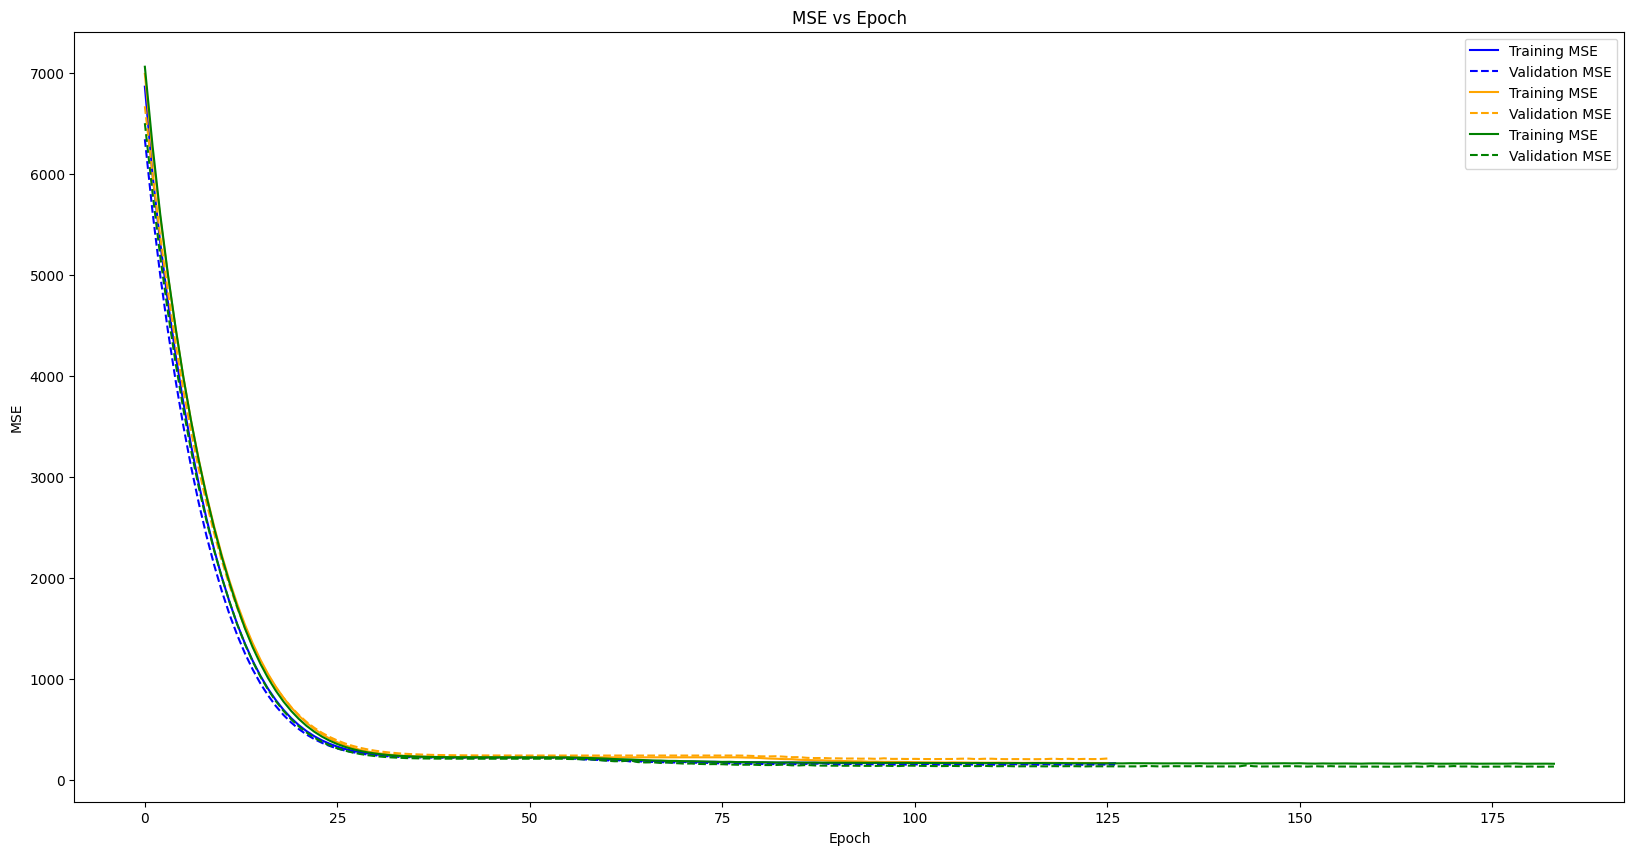

In [389]:
# Show MSE vs Epoch and save plot to file
plt.subplots(figsize=(20, 10))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

for i in range(K_FOLDS):
    plt.plot(train_mse[i], label='Training MSE', color=colors[i])
    plt.plot(val_mse[i], label='Validation MSE', color=colors[i], linestyle='dashed')
    plt.legend(loc='upper right')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('MSE vs Epoch')
    plt.savefig(os.path.join(ITERATION_FOLDER, "mse_vs_epoch_{}.png".format(i)))
    
plt.show()

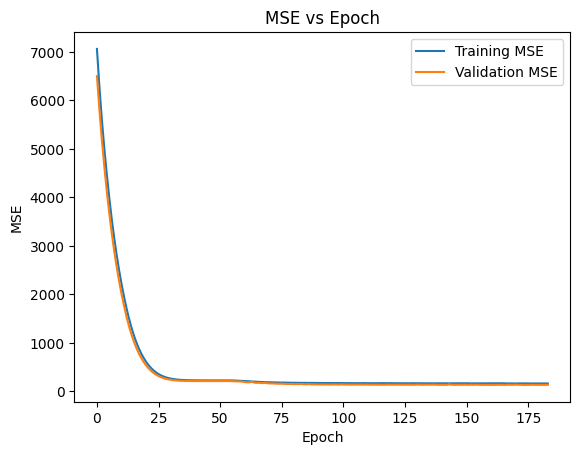

In [390]:
# Show MSE vs Epoch and save plot to file
plt.plot(train_mse[K_FOLDS - 1], label='Training MSE')
plt.plot(val_mse[K_FOLDS - 1], label='Validation MSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE vs Epoch')
plt.savefig(os.path.join(ITERATION_FOLDER, "mse_vs_epoch_last_only.png"))
    
plt.show()

### R2 score

In [391]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error

y_pred = model.predict(X_test)

R2 = r2_score(y_test, y_pred)
print("R2 Score: {}".format(R2))

MAPE = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE: {}".format(MAPE))

2/2 [==============================] - 0s 2ms/step
R2 Score: 0.47203021868531186
MAPE: 0.08397074228371618


### Scatter

2/2 [==============================] - 0s 5ms/step - loss: 99.0715 - mae: 7.2077
MSE: 99.07147979736328
RMSE: 9.953465717897625
MAE: 7.20771598815918
2/2 [==============================] - 0s 3ms/step
(39, 4)


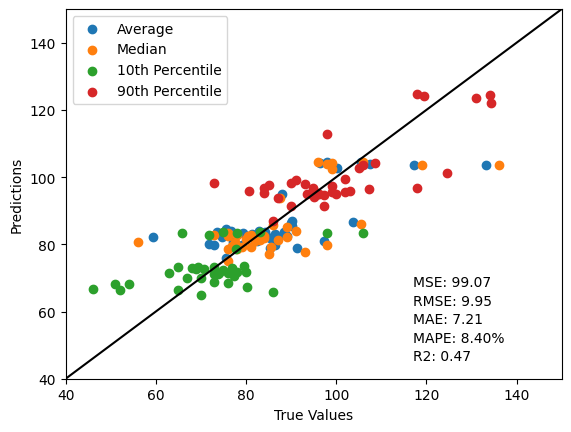

In [392]:
# Test model
TEST_EVALUATION = model.evaluate(X_test, y_test)
print("MSE:", TEST_EVALUATION[0])
print("RMSE:", np.sqrt(TEST_EVALUATION[0]))
print("MAE:", TEST_EVALUATION[1])

# scatter plot for all 4 individual values of the predictions
predictions = model.predict(X_test)

print(predictions.shape)

# Plot
plt.scatter(y_test[:, 0], predictions[:, 0], label="Average")
plt.scatter(y_test[:, 1], predictions[:, 1], label="Median")
plt.scatter(y_test[:, 2], predictions[:, 2], label="10th Percentile")
plt.scatter(y_test[:, 3], predictions[:, 3], label="90th Percentile")

plt.xlabel("True Values")
plt.ylabel("Predictions")

# # Plot x=y for reference
x = np.linspace(0, 200, 100)
y = x

plt.plot(x, y, color="black")

plt.xlim(40, 150)
plt.ylim(40, 150)

# Show MSE, RMSE, MAE
plt.annotate("MSE: {:.2f}".format(TEST_EVALUATION[0]), (0.7, 0.25), xycoords='axes fraction')
plt.annotate("RMSE: {:.2f}".format(np.sqrt(TEST_EVALUATION[0])), (0.7, 0.20), xycoords='axes fraction')
plt.annotate("MAE: {:.2f}".format(TEST_EVALUATION[1]), (0.7, 0.15), xycoords='axes fraction')
plt.annotate("MAPE: {:.2f}%".format(MAPE * 100), (0.7, 0.1), xycoords='axes fraction')
plt.annotate("R2: {:.2f}".format(R2), (0.7, 0.05), xycoords='axes fraction')

plt.legend()
plt.savefig(os.path.join(ITERATION_FOLDER, "scatter_plot.png"))
plt.show()

2/2 [==============================] - 0s 5ms/step - loss: 99.0715 - mae: 7.2077
MSE: 99.07147979736328
RMSE: 9.953465717897625
MAE: 7.20771598815918
2/2 [==============================] - 0s 3ms/step
(39, 4)
tf.Tensor(
[ 97.98850575  71.75641026  75.51612903  90.29487179  74.78205128
  84.20535714  81.34615385 133.18888889 107.42465753  88.04411765
  90.23809524 117.2967033   89.1147541   72.86813187  96.42857143
 103.82142857 105.44285714  91.33333333  82.37777778  85.36470588
  97.33333333  79.09302326  76.67241379  86.42372881  77.16666667
  73.58181818  84.16666667  90.07865169  76.06896552  59.46153846
  82.85057471 100.16666667  75.50909091  86.35714286  88.3559322
  84.36666667  85.41666667  88.41935484  79.43396226], shape=(39,), dtype=float64)
[104.43302   80.02209   75.85687   85.47991   82.03139   83.60581
  83.135284 103.752014 104.009346  94.92248   86.967415 103.752014
  82.41718   79.7304   104.223366  86.645294 104.3852    78.872154
  81.05674   81.953224  80.95948   7

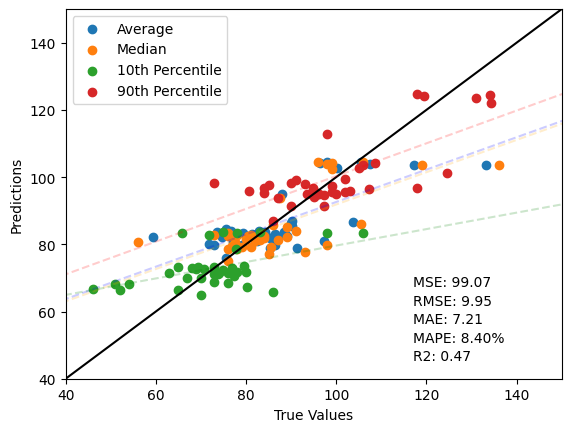

In [393]:
# Test model
TEST_EVALUATION = model.evaluate(X_test, y_test)
print("MSE:", TEST_EVALUATION[0])
print("RMSE:", np.sqrt(TEST_EVALUATION[0]))
print("MAE:", TEST_EVALUATION[1])

colors = ['blue', 'orange', 'green', 'red']

# scatter plot for all 4 individual values of the predictions
predictions = model.predict(X_test)

print(predictions.shape)

# Plot
plt.scatter(y_test[:, 0], predictions[:, 0], label="Average")
plt.scatter(y_test[:, 1], predictions[:, 1], label="Median")
plt.scatter(y_test[:, 2], predictions[:, 2], label="10th Percentile")
plt.scatter(y_test[:, 3], predictions[:, 3], label="90th Percentile")

plt.xlabel("True Values")
plt.ylabel("Predictions")

# # Plot x=y for reference
x = np.linspace(0, 200, 100)
y = x

plt.plot(x, y, color="black")

print(y_test[:, 0])
print(predictions[:, 0])

# Get a linear regression for the predictions
from sklearn.linear_model import LinearRegression
for i in range(4):
    reg = LinearRegression().fit(y_test[:, i].numpy().reshape(-1, 1), predictions[:, i].reshape(-1, 1))
    plt.plot(x, reg.predict(x.reshape(-1, 1)), color=colors[i], linestyle="dashed", alpha=0.2)

plt.xlim(40, 150)
plt.ylim(40, 150)

# Show MSE, RMSE, MAE
plt.annotate("MSE: {:.2f}".format(TEST_EVALUATION[0]), (0.7, 0.25), xycoords='axes fraction')
plt.annotate("RMSE: {:.2f}".format(np.sqrt(TEST_EVALUATION[0])), (0.7, 0.20), xycoords='axes fraction')
plt.annotate("MAE: {:.2f}".format(TEST_EVALUATION[1]), (0.7, 0.15), xycoords='axes fraction')
plt.annotate("MAPE: {:.2f}%".format(MAPE * 100), (0.7, 0.1), xycoords='axes fraction')
plt.annotate("R2: {:.2f}".format(R2), (0.7, 0.05), xycoords='axes fraction')

plt.legend()
plt.savefig(os.path.join(ITERATION_FOLDER, "scatter_plot_regressed.png"))
plt.show()

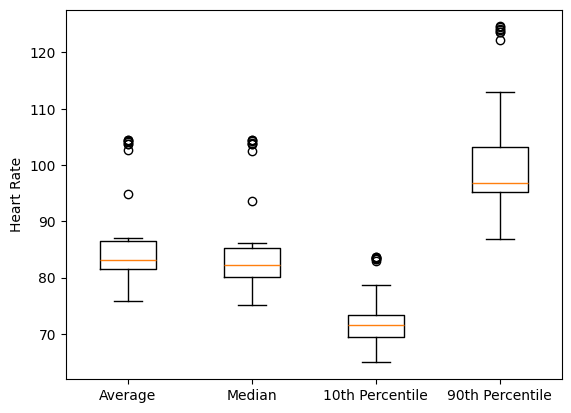

In [394]:
# Show whisker plot of the predictions
plt.boxplot(predictions)
plt.xticks([1, 2, 3, 4], ["Average", "Median", "10th Percentile", "90th Percentile"])
plt.ylabel("Heart Rate")
plt.savefig(os.path.join(ITERATION_FOLDER, "whisker_plot.png"))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


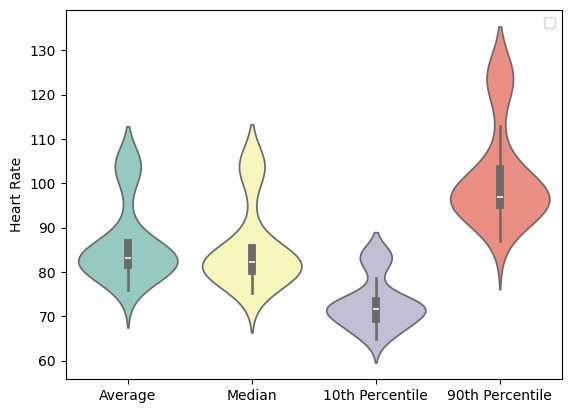

In [395]:
# Show violin plot of the predictions
sns.violinplot(predictions, palette="Set3")
plt.xticks([0, 1, 2, 3], ["Average", "Median", "10th Percentile", "90th Percentile"])
plt.ylabel("Heart Rate")
plt.legend()
plt.savefig(os.path.join(ITERATION_FOLDER, "violin_plot.png"))
plt.show()

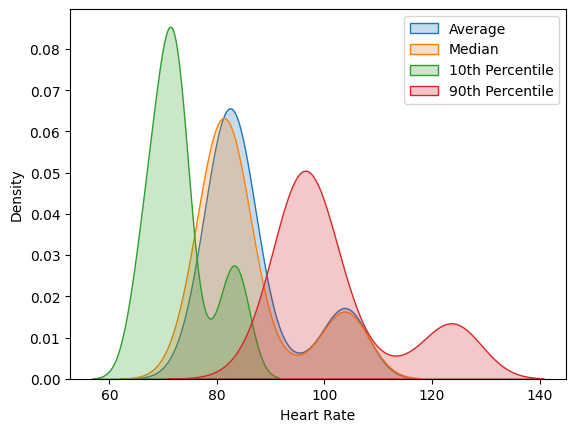

In [396]:
# Show density plot of the predictions and label the densities
sns.kdeplot(predictions[:, 0], fill=True, label="Average")
sns.kdeplot(predictions[:, 1], fill=True, label="Median")
sns.kdeplot(predictions[:, 2], fill=True, label="10th Percentile")
sns.kdeplot(predictions[:, 3], fill=True, label="90th Percentile")
plt.xlabel("Heart Rate")
plt.legend()
plt.savefig(os.path.join(ITERATION_FOLDER, "density_plot.png"))
plt.show()

## Save model to index file

In [398]:
# Make sure index file exists
INDEX_FILE_PATH = os.path.join(MODELS_FOLDER, "index.csv")
if not os.path.exists(INDEX_FILE_PATH):
    with open(INDEX_FILE_PATH, 'w') as f:
        f.write("INDEX, MODEL_NAME, LAYERS, RUN_EPOCHS, BATCH_SIZE, LEARNING_RATE, MSE, RMSE, MAE, R2, MAPE\n")

# Creates layer string like "32dense-64dense-128dense-10dense"
def get_layer_string(model):
    return "-".join([str(layer.units) + layer.name.split("_")[0] for layer in model.layers])

# Create method for creating short summary string
def get_model_summary(model, epochs, batch_size, lr):
    # Create layer string like "32dense-64dense-128dense-10dense"
    return "{}-e{}-b{}-lr{}".format(get_layer_string(model), epochs, batch_size, lr)

def get_csv_entry(model, epochs, folds, batch_size, lr, mse, rmse, mae, r2, mape):
    return "{},{},{},{},{},{},{},{},{},{},{},{}\n".format(CURRENT_MODEL_ITERATION, model.name, get_layer_string(model), epochs, folds, batch_size, lr, mse, rmse, mae, r2, mape)
    
# Save Entire model
MODEL_FILE_PATH = os.path.join(ITERATION_FOLDER, "model.keras")
model.save(MODEL_FILE_PATH)

# Save model config
MODEL_CONFIG_FILE_PATH = os.path.join(ITERATION_FOLDER, "model_config.json")
with open(MODEL_CONFIG_FILE_PATH, 'w') as f:
    f.write(model.to_json())
    
# Append to index file
with open(INDEX_FILE_PATH, 'a') as f:
    f.write(get_csv_entry(model, RUN_EPOCHS, K_FOLDS, BATCH_SIZE, LEARNING_RATE, TEST_EVALUATION[0], np.sqrt(TEST_EVALUATION[0]), TEST_EVALUATION[1], R2, MAPE))

## Testing model manually

In [399]:
# Print first sample
print (X_test[0])

# Volleybal
sample_vl = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 90, 1, 21, 5]

# Cooking
sample_c = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1 ,0, 0, 0, 60, 1, 21, 5]

# Meeting
sample_m = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 30, 1, 21, 5]

sample_m_vl = [0, 1, 0, 1, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 60, 1, 8, 1]
sample_m_vl2 = [0, 1, 0, 1, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 60, 1, 21, 1]

# Predict
prediction = model.predict([sample_vl])
print(prediction)

prediction = model.predict([sample_c])
print(prediction)

prediction = model.predict([sample_m])
print(prediction)

prediction = model.predict([sample_m_vl])
print(prediction)
prediction = model.predict([sample_m_vl2])
print(prediction)

tf.Tensor([ 0  0  0  1  0  0  0  0  0  0  0  0  0 90  5 19  2], shape=(17,), dtype=int64)
1/1 [==============================] - 0s 102ms/step
[[103.5997   103.499084  83.30202  123.346924]]
1/1 [==============================] - 0s 42ms/step
[[84.18728  83.58271  73.51968  96.305214]]
1/1 [==============================] - 0s 46ms/step
[[83.42922 82.84731 73.0907  95.26052]]
1/1 [==============================] - 0s 45ms/step
[[ 93.88376  93.46359  77.63626 110.83539]]
1/1 [==============================] - 0s 43ms/step
[[ 88.429924  88.04809   76.219025 101.78701 ]]


## Correlation Matrix

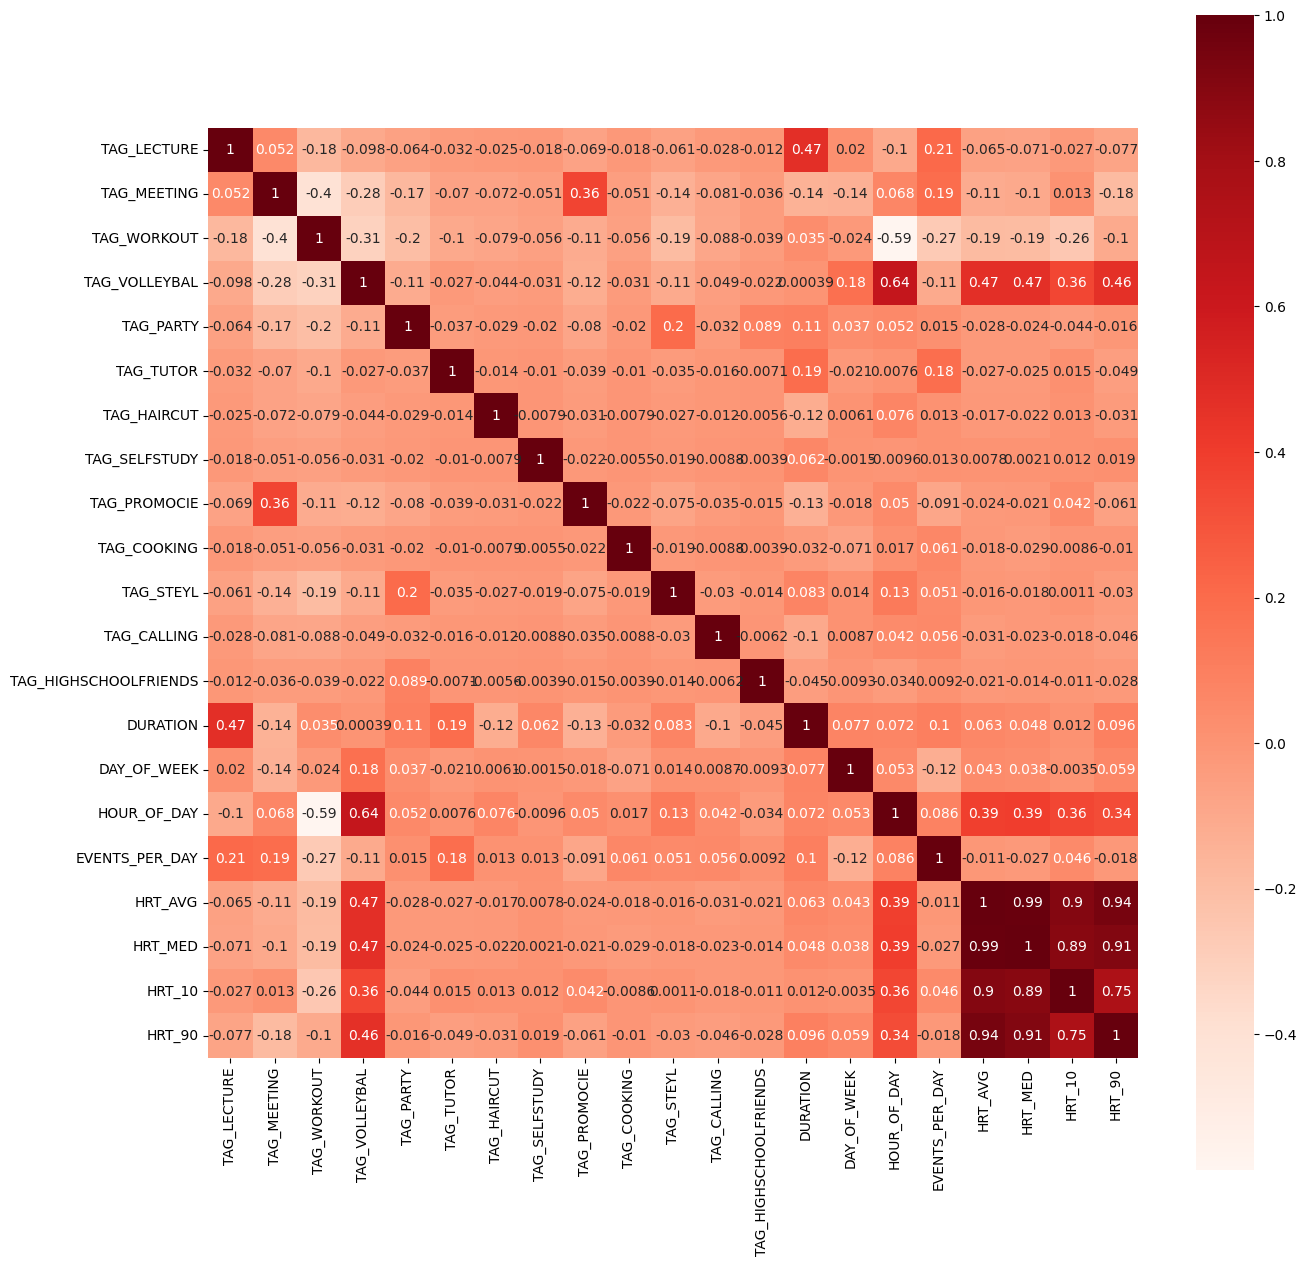

In [400]:
# Correlations between features and targets
train_data = pd.concat([X_train, y_train], axis=1)
corr = train_data.corr()
fig = plt.figure(figsize=(15, 15))

sns.heatmap(corr, square=True, annot=True, cmap=plt.cm.Reds)
plt.savefig(os.path.join(ITERATION_FOLDER, "correlation_heatmap.png"))
plt.show()

# SHAP

In [401]:
import shap

shap.initjs()

In [402]:
# Convert to numpy arrays
X_train_np = X_train_current_fold.numpy()
X_test_np = X_test.numpy()

In [403]:
def f(X):
    return model.predict(X)

## SHAP Inspecting for a manual prediction

In [404]:
explainer = shap.KernelExplainer(f, X_train_np[:50])

test_np = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0 ,0, 0, 0, 90, 1, 21, 5])
shap_values = explainer.shap_values(test_np)

FOLDER_NAME = "shap_plots"
integer_list = [int(x) for x in test_np.__str__().strip('[]').split()]
string_list = [str(x) for x in integer_list]
THIS_TEST_NAME = '-'.join(string_list)

os.makedirs(os.path.join(ITERATION_FOLDER, FOLDER_NAME, THIS_TEST_NAME), exist_ok=True)

# Save plots
for i in range(4):
    shap.plots.force(explainer.expected_value[i], shap_values[i], feature_names=feature_headers, matplotlib=True, show=False)
    plt.savefig(os.path.join(ITERATION_FOLDER, FOLDER_NAME, THIS_TEST_NAME, "{}.png".format(target_headers[i])))
    plt.close()


2/2 [==============================] - 0s 3ms/step


3241/3241 [==============================] - 5s 2ms/step


In [405]:
# Multi explination
shap_values50 = explainer.shap_values(X_train_np[:50], nsamples=50)


  0%|          | 0/50 [00:00<?, ?it/s]

79/79 [==============================] - 0s 1ms/step


In [406]:
shap.force_plot(explainer.expected_value[1], shap_values50[1], feature_headers)